In [9]:
"""Miscellaneous utility functions."""
import os
from functools import reduce

from PIL import Image
import numpy as np
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import matplotlib.pyplot as plt

def compose(*funcs):
    """Compose arbitrarily many functions, evaluated left to right.

    Reference: https://mathieularose.com/function-composition-in-python/
    """
    # return lambda x: reduce(lambda v, f: f(v), funcs, x)
    if funcs:
        return reduce(lambda f, g: lambda *a, **kw: g(f(*a, **kw)), funcs)
    else:
        raise ValueError('Composition of empty sequence not supported.')

def letterbox_image(image, size):
    '''resize image with unchanged aspect ratio using padding'''
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image

def rand(a=0, b=1):
    return np.random.rand()*(b-a) + a

def get_random_data(annotation_line, input_shape, random=True, max_boxes=20, jitter=.3, hue=.1, sat=1.5, val=1.5, proc_img=True):
    '''random preprocessing for real-time data augmentation'''
    '''
    @param annotation_line 一个训练样本,形如：img_file 6,1,314,262,19 40,97,121,411,4 137,36,169,109,14 180,36,216,104,14 96,39,123,103,14
    '''
    line = annotation_line.split() #=>['img_file', '6,1,314,262,19', '40,97,121,411,4', '137,36,169,109,14', '180,36,216,104,14', '96,39,123,103,14']
    image = Image.open(line[0])    #=>img_file
    iw, ih = image.size            #=>(486,500)尺寸大小不固定
    h, w = input_shape             #=>(416,416)
    box = np.array([np.array(list(map(int,box.split(',')))) for box in line[1:]]) #=>分离bounding box =>[[6,1,314,262,19],[40,97,121,411,4],[137,36,169,109,14],[180,36,216,104,14],[96,39,123,103,14]]

    if not random:
        # resize image
        scale = min(w/iw, h/ih) #取较小缩放比例
        nw = int(iw*scale)      #以较小缩放比例重设原图像宽度
        nh = int(ih*scale)      #以较小缩放比例重设原图像高度
        dx = (w-nw)//2          #左右边隙
        dy = (h-nh)//2          #上下边隙   
        image_data=0
        if proc_img:
            image = image.resize((nw,nh), Image.BICUBIC)
            new_image = Image.new('RGB', (w,h), (128,128,128))
            new_image.paste(image, (dx, dy))
            image_data = np.array(new_image)/255. #归一化处理

        # correct boxes
        box_data = np.zeros((max_boxes,5))
        if len(box)>0:
            np.random.shuffle(box)
            if len(box)>max_boxes: box = box[:max_boxes] #最多处理20个box
            box[:, [0,2]] = box[:, [0,2]]*scale + dx     #等比例缩放偏移处理
            box[:, [1,3]] = box[:, [1,3]]*scale + dy     #等比例缩放偏移处理
            box_data[:len(box)] = box

        return image_data, box_data

    # resize image
    new_ar = w/h * rand(1-jitter,1+jitter)/rand(1-jitter,1+jitter)
    scale = rand(.25, 2)
    if new_ar < 1:
        nh = int(scale*h)
        nw = int(nh*new_ar)
    else:
        nw = int(scale*w)
        nh = int(nw/new_ar)
    image = image.resize((nw,nh), Image.BICUBIC)

    # place image
    dx = int(rand(0, w-nw))
    dy = int(rand(0, h-nh))
    new_image = Image.new('RGB', (w,h), (128,128,128))
    new_image.paste(image, (dx, dy))
    image = new_image

    # flip image or not
    flip = rand()<.5
    if flip: image = image.transpose(Image.FLIP_LEFT_RIGHT)

    # distort image
    hue = rand(-hue, hue)
    sat = rand(1, sat) if rand()<.5 else 1/rand(1, sat)
    val = rand(1, val) if rand()<.5 else 1/rand(1, val)
    x = rgb_to_hsv(np.array(image)/255.)
    x[..., 0] += hue
    x[..., 0][x[..., 0]>1] -= 1
    x[..., 0][x[..., 0]<0] += 1
    x[..., 1] *= sat
    x[..., 2] *= val
    x[x>1] = 1
    x[x<0] = 0
    image_data = hsv_to_rgb(x) # numpy array, 0 to 1

    # correct boxes
    box_data = np.zeros((max_boxes,5))
    if len(box)>0:
        np.random.shuffle(box)
        box[:, [0,2]] = box[:, [0,2]]*nw/iw + dx
        box[:, [1,3]] = box[:, [1,3]]*nh/ih + dy
        if flip: box[:, [0,2]] = w - box[:, [2,0]]
        box[:, 0:2][box[:, 0:2]<0] = 0
        box[:, 2][box[:, 2]>w] = w
        box[:, 3][box[:, 3]>h] = h
        box_w = box[:, 2] - box[:, 0]
        box_h = box[:, 3] - box[:, 1]
        box = box[np.logical_and(box_w>1, box_h>1)] # discard invalid box
        if len(box)>max_boxes: box = box[:max_boxes]
        box_data[:len(box)] = box

    return image_data, box_data

type(img_data): <class 'numpy.ndarray'>
img_data.shape: (416, 416, 3)
type(box_data): <class 'numpy.ndarray'>
box_data.shape: (20, 5)


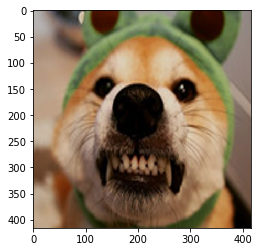

In [12]:
annotation_line='%s/data/1.jpg 10,20,100,100,1 50,20,150,100,2'%(os.getenv('HOME'))
input_shape=(416,416)
img_data,box_data=get_random_data(annotation_line, input_shape, random=True, max_boxes=20, jitter=.3, hue=.1, sat=1.5, val=1.5, proc_img=True)
print('type(img_data):',type(img_data))
print('img_data.shape:',img_data.shape)
print('type(box_data):',type(box_data))
print('box_data.shape:',box_data.shape)
plt.imshow(img_data)
plt.show()